## Basics of association rules and important metrics

In this notebook we will get familiar with the most important tasks and tool you should be aware of when performing association rules analysis with Python. We will start with some basic examples and calculation of the measures introduced in the lecture, and then work with some specific functions to run the apriori algorithm and find the most relevant rules.

In [1]:
# Importing the important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Before you run this code the first time, you have to install this library as it is not partof the base anaconda
# You can do it using the Anaconda Prompt (check the video on how to install libraries) using the code:
# conda install mlxtend -c conda-forge
import mlxtend.preprocessing
import mlxtend.frequent_patterns

Let's start with a simple example. Suppose you have the list of transactions used as illustration in the lecture. Each transaction is represented as a list of strings, and they are combined into a list of transactions.

In [2]:
shopping_data = [['bread', 'milk'], ['bread', 'diaper', 'beer','eggs'], ['milk', 'diaper', 'beer', 'coke'],
             ['bread', 'milk', 'diaper', 'beer'], ['bread', 'milk', 'diaper', 'coke']]

In [4]:
# We can calculate the number of transactions that contain beer (support count)
# Note: check list comprehensions if formulation is not clear

beer_count =sum([1 for l in shopping_data if 'beer' in l])

print('We have', beer_count, 'baskets with beer.')

We have 3 baskets with beer.


In [5]:
# We can also calculate the support count for a pair of products, for example beer and diaper

combo_count =sum([1 for l in shopping_data if ('beer' in l) and ('diaper' in l)])

print('We have', combo_count, 'baskets with beer and diaper.')

We have 3 baskets with beer and diaper.


In [6]:
# We can also create a simple function for checking any subset of items for support count

def support_count(transaction_list, item_list):
    combo_count =sum([1 for l in transaction_list if (all(x in l for x in item_list))])

    print('We have', combo_count, 'baskets with', item_list)

In [8]:
support_count(shopping_data, ['beer', 'diaper', 'bread'])

We have 2 baskets with ['beer', 'diaper', 'bread']


In [9]:
# Let's look at another small example dataset of grocery shopping transactions
# This is a format in which in practice many times we receive transactional data
# One row for each transaction, and the list of items (individual items separated with comma,
# or sometimes another symbol)

grocery_data = pd.read_csv('small_grocery_store.csv')

grocery_data.head()

,Transaction
0,"milk,bread,biscuit"
1,"bread,milk,biscuit,cereal"
2,"bread,tea"
3,"jam,bread,milk"
4,"tea,biscuit"


In [10]:
# In order to convert the data in the format that we can use with the created function
# we need to create a list for each element in the dataframe

transactions = grocery_data['Transaction'].apply(lambda t: t.split(','))
transactions.head()

0            [milk, bread, biscuit]
1    [bread, milk, biscuit, cereal]
2                      [bread, tea]
3                [jam, bread, milk]
4                    [tea, biscuit]
Name: Transaction, dtype: object

In [11]:
# Finally combine the individual lists into one list
grocery_list = list(transactions)

grocery_list

[['milk', 'bread', 'biscuit'],
 ['bread', 'milk', 'biscuit', 'cereal'],
 ['bread', 'tea'],
 ['jam', 'bread', 'milk'],
 ['tea', 'biscuit'],
 ['bread', 'tea'],
 ['tea', 'cereal'],
 ['bread', 'tea', 'biscuit'],
 ['jam', 'bread', 'tea'],
 ['bread', 'milk'],
 ['coffee', 'orange', 'biscuit', 'cereal'],
 ['coffee', 'orange', 'biscuit', 'cereal'],
 ['coffee', 'sugar'],
 ['bread', 'coffee', 'orange'],
 ['bread', 'sugar', 'biscuit'],
 ['coffee', 'sugar', 'cereal'],
 ['bread', 'sugar', 'biscuit'],
 ['bread', 'coffee', 'sugar'],
 ['bread', 'coffee', 'sugar'],
 ['tea', 'milk', 'coffee', 'cereal']]

In [12]:
# Now we can use the simple created function
support_count(grocery_list, ['coffee', 'sugar'])

We have 4 baskets with ['coffee', 'sugar']


In [13]:
# While with small examples working with lists is fine, in practice we want the data in a DataFrame
# in the so called transactiona format:
# each row represents a transaction and each column represent one item.
# In a cell we have 1 (True), if the item (column) is included in transaction (row), and we have 0 (False otherwise)

# We can obtain the required format with a preprocessing function from mlxtend
# This line will idnetify the unique items
encoder = mlxtend.preprocessing.TransactionEncoder().fit(grocery_list)

# This line will create a transactional format 
encoded_data = encoder.transform(grocery_list)

# Finally we convert it to dataframe
df_grocery = pd.DataFrame(encoded_data, columns = encoder.columns_)

print(df_grocery)

    biscuit  bread  cereal  coffee    jam   milk  orange  sugar    tea
0      True   True   False   False  False   True   False  False  False
1      True   True    True   False  False   True   False  False  False
2     False   True   False   False  False  False   False  False   True
3     False   True   False   False   True   True   False  False  False
4      True  False   False   False  False  False   False  False   True
5     False   True   False   False  False  False   False  False   True
6     False  False    True   False  False  False   False  False   True
7      True   True   False   False  False  False   False  False   True
8     False   True   False   False   True  False   False  False   True
9     False   True   False   False  False   True   False  False  False
10     True  False    True    True  False  False    True  False  False
11     True  False    True    True  False  False    True  False  False
12    False  False   False    True  False  False   False   True  False
13    

In [14]:
# When we have the data inthis form, it is very easy to calcualte support count and support
# For support count, as it is the number of transactions in which the item is present, we simply calculate the 
# sum of the columns (remember: True is 1, False is 0)

df_grocery.sum()

biscuit     8
bread      13
cereal      6
coffee      8
jam         2
milk        5
orange      3
sugar       6
tea         7
dtype: int64

In [15]:
# Support is support count divided by the total number of transactions
# When we have data with 0-1 values only, this is actually the mean
# So the support for each individual item can be easily calculated applying mean to the dataframe

df_grocery.mean()

biscuit    0.40
bread      0.65
cereal     0.30
coffee     0.40
jam        0.10
milk       0.25
orange     0.15
sugar      0.30
tea        0.35
dtype: float64

In [16]:
# By combining the columns of this dataframe, we can easily look at 
# itemsets and rules and calculate their support
# For example, the support count of two items together, e.g. coffee and bread,
# is the number of transactions when they appear together
# So we need the rows when both columns 'coffee' and 'bread' are True
# We can do this with the logical_and fucntion

coffee_bread = np.logical_and(df_grocery['coffee'], df_grocery['bread'])

# Compute the support count
print('The support count of coffee and bread is ', coffee_bread.sum())

# Compute the support
print('The support of coffee and bread is ', coffee_bread.mean())

The support count of coffee and bread is  3
The support of coffee and bread is  0.15


In [17]:
# We can do the same thing with more than two items

coffee_bread_sugar = np.logical_and(np.logical_and(df_grocery['coffee'], df_grocery['bread']), df_grocery['sugar'])

# Compute the support count
print('The support count of coffee, bread and sugar is ', coffee_bread_sugar.sum())

# Compute the support
print('The support of coffee bread and sugar is ', coffee_bread_sugar.mean())

The support count of coffee, bread and sugar is  2
The support of coffee bread and sugar is  0.1


In [18]:
# Additional measures that we can calculate simply include confidence and lif

# Confidence is the support or the combined itemset divided by the support of the individual items

# First we can calculate the support of bread and coffee

coffe_bread_sup = np.logical_and(df_grocery['bread'], df_grocery['coffee']).mean()

# Then the support separately for coffee and bread

coffee_sup = df_grocery.coffee.mean()
bread_sup = df_grocery.bread.mean()

# To calculate the confidence of the rule Bread -> Coffee, we need to divide by the support of bread
bread_coffee_conf = coffe_bread_sup / bread_sup

print('The confidence of the rule Bread -> Coffee is', bread_coffee_conf)

# To calculate the confidence of the rule Coffee -> Bread, we need to divide by the support of coffee
coffee_bread_conf = coffe_bread_sup / coffee_sup

print('The confidence of the rule Coffee -> Bread is', coffee_bread_conf)

The confidence of the rule Bread -> Coffee is 0.23076923076923075
The confidence of the rule Coffee -> Bread is 0.37499999999999994


In [19]:
# In order to calculate lift, we need to divied by the product of the individual support values

coffee_bread_lift = coffe_bread_sup / (bread_sup * coffee_sup)

print('The lift of the rule Coffee -> Bread is', coffee_bread_lift)

The lift of the rule Coffee -> Bread is 0.5769230769230769


In [ ]:
# There are other alternative metrics, such as leverage, conviction, etc., see more in the DataCamp course

## Apriori algorithm 

As we can see, we can easily calculate important metrics for items and itemsets. However, in order to find what are the mostimportant rules, we would need to check all the possible combinations, i.e. iterating over 2^n possible item sets. For this, it is much better to use optimized functions, making use of the ideas of Apriori algorithm motivated in the lecture (altough it would be possible to implement an algorithm continuing the above steps). We will makes use of an implementation from the mlxtend library.

In [20]:
# In this case we will work with a larger dataset
# As we can see here, the format is quite different, but this is also something that you frequently encounter in practice

df = pd.read_csv('online_retail.csv')

# We need to convert the descritpion column, as there are some numeric values

df['Description'] = df['Description'].astype('str')

df.head(10)

,InvoiceNo,StockCode,Description
0,562583,35637A,IVORY STRING CURTAIN WITH POLE
1,562583,35638A,PINK AND BLACK STRING CURTAIN
2,562583,84927F,PSYCHEDELIC TILE HOOK
3,562583,22425,ENAMEL COLANDER CREAM
4,562583,16008,SMALL FOLDING SCISSOR(POINTED EDGE)
5,562583,22232,JIGSAW TOADSTOOLS 3 PIECE
6,562584,84945,MULTI COLOUR SILVER T-LIGHT HOLDER
7,562584,21411,GINGHAM HEART DOORSTOP RED
8,562584,22083,PAPER CHAIN KIT RETROSPOT
9,562584,21621,VINTAGE UNION JACK BUNTING


In [22]:
# In order to get the data in the right format, we need:
# one row for each invoice number, and the value for that should be a list of items included in the invoice
# We can achieve this by using group_by based on InvoiceNo, and the function will combine the value from 
# the column Description into a list

df_list = df.groupby(['InvoiceNo'])['Description'].apply(list).values.tolist()

df_list[:5]

[['DOORMAT RED RETROSPOT',
  'DOORMAT WELCOME SUNRISE',
  'DOORMAT MULTICOLOUR STRIPE',
  'PACK OF 72 SKULL CAKE CASES',
  'PACK OF 60 PINK PAISLEY CAKE CASES',
  'PACK OF 60 MUSHROOM CAKE CASES',
  'PACK OF 72 RETROSPOT CAKE CASES',
  '72 SWEETHEART FAIRY CAKE CASES',
  '60 TEATIME FAIRY CAKE CASES',
  'SET OF 36 PAISLEY FLOWER DOILIES',
  'SET OF 36 MUSHROOM PAPER DOILIES',
  'SET OF 72 SKULL PAPER  DOILIES',
  'SET/10 BLUE POLKADOT PARTY CANDLES',
  'SET/10 PINK POLKADOT PARTY CANDLES',
  'SET/10 IVORY POLKADOT PARTY CANDLES',
  'SET/10 RED POLKADOT PARTY CANDLES'],
 ['SET OF 6 SPICE TINS PANTRY DESIGN',
  'PANTRY WASHING UP BRUSH',
  'SET OF 36 TEATIME PAPER DOILIES',
  'SET OF 3 CAKE TINS PANTRY DESIGN ',
  'SET OF 4 PANTRY JELLY MOULDS',
  'TEA TIME DES TEA COSY',
  'SET 2 PANTRY DESIGN TEA TOWELS',
  ' SET 2 TEA TOWELS I LOVE LONDON ',
  'PARTY CONES CANDY ASSORTED',
  'PINK HAPPY BIRTHDAY BUNTING',
  '3 TRADITIONAl BISCUIT CUTTERS  SET',
  'PAPER BUNTING COLOURED LACE',
  'COTT

In [23]:
# And from this we can create a transactional form as above

encoder = mlxtend.preprocessing.TransactionEncoder().fit(df_list)

# This line will create a transactional format 
encoded_data = encoder.transform(df_list)

# Finally we convert it to dataframe
df_trans = pd.DataFrame(encoded_data, columns = encoder.columns_)

print(df_trans.head())

    4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

    DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   NINE DRAWER OFFICE TIDY  \
0               False                         False                     False   
1               False                         False                     False   
2               False                         False                     False   
3               False                         False                     False   
4               False                         False                     False   

    OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
0                        False        

In [24]:
# We can check that we have 9709 transactions and 3461 items

df_trans.shape

(9709, 3461)

In [25]:
# The first step is to check for the most frequent itemsets
# We can experiment with different parameters, but for brief check we typically want to:
# limit the number of items: max_len (3 means maximum 3 items in an itemset)
# require a minimum support value: min_support (0.02 means that it should have 2% support)

frequent_itemsets = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.02, max_len = 3, use_colnames = True)

# We can chech the results
print(frequent_itemsets.head())

    support                               itemsets
0  0.020805        (12 PENCIL SMALL TUBE WOODLAND)
1  0.021629  (15CM CHRISTMAS GLASS BALL 20 LIGHTS)
2  0.020187  (3 DRAWER ANTIQUE WHITE WOOD CABINET)
3  0.022247   (3 HEARTS HANGING DECORATION RUSTIC)
4  0.023689             (3 STRIPEY MICE FELTCRAFT)


In [29]:
# Changing the parameters can impact heavily on how many itemsets we retrieve
# When using min_support 0.05, we obtain 20 frequent itemsets, while with 0.02, we obtain 332 frequent itemsets

frequent_itemsets_1 = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.05, max_len = 3, use_colnames = True)

frequent_itemsets_2 = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.02, max_len = 3, use_colnames = True)

# Print the number of frequent itemsets
print('Number of frequent itemsets with min_support 0.05:', len(frequent_itemsets_1),)
print('Number of frequent itemsets with min_support 0.02:', len(frequent_itemsets_2))

Number of frequent itemsets with min_support 0.05: 20
Number of frequent itemsets with min_support 0.02: 332


In [30]:
# As we know from the theory, a rule can be important if the involved itemset is frequent enough
# So we can restrict the search for rules to the output of the above apriori runs
# (or based on any other support specifications)

# We can make use of a new function, association_rules to generate the relevant rules based on the identified frequent itemsets
# We can specify an additional metric to assess the quality of the rule
# We can simply start with support (as we know, the support of a rule isthe support of all the items divided by the 
# support of the antecedent)

# First we generate the rules based on the two above created frequent itemsets 
# and check the number of rules generated, using an additional 0.001

rules_1 = mlxtend.frequent_patterns.association_rules(frequent_itemsets_1, metric = "support", min_threshold = 0.001)

# Compute all association rules for frequent_itemsets_2
rules_2 = mlxtend.frequent_patterns.association_rules(frequent_itemsets_2, metric = "support", min_threshold = 0.001)

# Print the number of association rules generated
# As we can see, with the very high original restriction on support (0.05), we do not get any relevant rules
# while with the weak restriction 0.02, we get 154 rules
print(len(rules_1), len(rules_2))

0 154


In [31]:
# In the created rules dataframe we have a lot of useful information, but it is alwasy up to us
# to decide whether they are meaningful from business perspective

rules_2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PAPER CHAIN KIT 50'S CHRISTMAS ),(60 CAKE CASES VINTAGE CHRISTMAS),0.092697,0.047482,0.021011,0.226667,4.773767,0.016610,1.231705
1,(60 CAKE CASES VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.047482,0.092697,0.021011,0.442516,4.773767,0.016610,1.627496
2,(60 CAKE CASES VINTAGE CHRISTMAS),(SET OF 20 VINTAGE CHRISTMAS NAPKINS),0.047482,0.046349,0.020393,0.429501,9.266725,0.018193,1.671609
3,(SET OF 20 VINTAGE CHRISTMAS NAPKINS),(60 CAKE CASES VINTAGE CHRISTMAS),0.046349,0.047482,0.020393,0.440000,9.266725,0.018193,1.700926
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.044701,0.048306,0.031826,0.711982,14.739081,0.029667,3.304283


In [32]:
# We can go throguh the same process making use of other metrics, such as confidence or lift
# depending on the business objective

# First we use apriori with some support thresholds and maximum number of items
frequent_itemsets = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.02, max_len = 4, use_colnames = True)

# Thhen we determine the relevant rules based on lift (as we know, 1.0 is the critical value)
rules = mlxtend.frequent_patterns.association_rules(frequent_itemsets, metric = "lift", min_threshold = 1.0)

# Print association rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PAPER CHAIN KIT 50'S CHRISTMAS ),(60 CAKE CASES VINTAGE CHRISTMAS),0.092697,0.047482,0.021011,0.226667,4.773767,0.016610,1.231705
1,(60 CAKE CASES VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.047482,0.092697,0.021011,0.442516,4.773767,0.016610,1.627496
2,(60 CAKE CASES VINTAGE CHRISTMAS),(SET OF 20 VINTAGE CHRISTMAS NAPKINS),0.047482,0.046349,0.020393,0.429501,9.266725,0.018193,1.671609
3,(SET OF 20 VINTAGE CHRISTMAS NAPKINS),(60 CAKE CASES VINTAGE CHRISTMAS),0.046349,0.047482,0.020393,0.440000,9.266725,0.018193,1.700926
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.044701,0.048306,0.031826,0.711982,14.739081,0.029667,3.304283
...,...,...,...,...,...,...,...,...,...
149,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...",(WOODEN TREE CHRISTMAS SCANDINAVIAN),0.035843,0.028633,0.021011,0.586207,20.472960,0.019985,2.347470
150,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN ST...",(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.025028,0.045628,0.021011,0.839506,18.399019,0.019869,5.946473
151,(WOODEN HEART CHRISTMAS SCANDINAVIAN),"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN ST...",0.045628,0.025028,0.021011,0.460497,18.399019,0.019869,1.807165
152,(WOODEN TREE CHRISTMAS SCANDINAVIAN),"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...",0.028633,0.035843,0.021011,0.733813,20.472960,0.019985,3.622103


In [33]:
# Similarly with confidence
# First we use apriori with some support thresholds and maximum number of items
frequent_itemsets = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.02, max_len = 4, use_colnames = True)

# Thhen we determine the relevant rules based on confidence and critical value 0.5
rules = mlxtend.frequent_patterns.association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.5)

# Print association rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.044701,0.048306,0.031826,0.711982,14.739081,0.029667,3.304283
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.048306,0.044701,0.031826,0.658849,14.739081,0.029667,2.800221
2,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG PINK POLKADOT),0.041096,0.029251,0.021526,0.523810,17.907277,0.020324,2.038572
3,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.029251,0.041096,0.021526,0.735915,17.907277,0.020324,3.631050
4,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG SUKI DESIGN),0.041096,0.033268,0.020599,0.501253,15.067079,0.019232,1.938322
...,...,...,...,...,...,...,...,...,...
64,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN TREE CHRISTMAS SCANDINAVIAN),0.045628,0.028633,0.025028,0.548533,19.157210,0.023722,2.151577
65,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN T...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.022350,0.045628,0.021011,0.940092,20.603510,0.019992,15.930675
66,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...",(WOODEN TREE CHRISTMAS SCANDINAVIAN),0.035843,0.028633,0.021011,0.586207,20.472960,0.019985,2.347470
67,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN ST...",(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.025028,0.045628,0.021011,0.839506,18.399019,0.019869,5.946473


In [34]:
# When we obtain a large amount of rules, we typically want to filter more
# and for this we can make use of all the information that is included in the rules dataframe

# Apply a 0.02 antecedent support threshold, 0.01 consequent support threshold, 
# 0.60 confidence threshold, and 12.50 lift threshold

filtered_rules = rules[(rules['antecedent support'] > 0.02) & (rules['consequent support'] > 0.01) & 
                       (rules['confidence'] > 0.60) & (rules['lift'] > 12.50)]

# Print remaining rule
filtered_rules[['antecedents','consequents']]

,antecedents,consequents
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN)
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED )
3,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG)
5,(CHARLOTTE BAG SUKI DESIGN),(RED RETROSPOT CHARLOTTE BAG)
10,(CHRISTMAS CRAFT TREE TOP ANGEL),(CHRISTMAS CRAFT LITTLE FRIENDS)
12,(CHRISTMAS CRAFT WHITE FAIRY ),(CHRISTMAS CRAFT LITTLE FRIENDS)
15,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER)
16,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER)
17,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER )
18,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER)


## Visualization
Finally, we look at two basic techniques to visualize different part sof the analysis in an easily interpretable way. First, we look at how to represent the rules together with the support in a compact form using a heatmap. Second, we will look at a simple way to look at what thresholds we could choose for the selected metric.

In [ ]:
# In order to print the items properly, we combine the items from the set they are represented in the rules
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# We can generate a heatmap, in which the support is presented, and we can items that are in several strong rules
# by looking at clusters of colored squares

pivot = rules.pivot(index='consequents', columns='antecedents', values='support')
sns.heatmap(pivot)

plt.show()

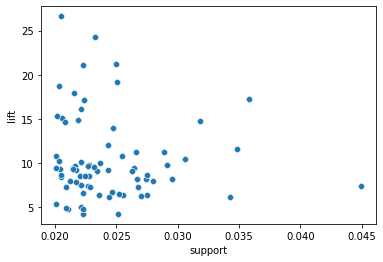

In [36]:
# For the last example, we can generate new rules based on specifications

frequent_itemsets = mlxtend.frequent_patterns.apriori(df_trans, min_support = 0.02, use_colnames = True, max_len = 2)
rules = mlxtend.frequent_patterns.association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.0)

# Based on the new rules, we can generate scatterplot using support and confidence
# Based on this plot we can quickly see how many rules we would obtain if we further constrain support/confidence
# For example, requiring confidence higher than 0.8 would imply that we will have one point (rule) left

sns.scatterplot(x = "support", y = "lift", data = rules)
plt.show()

In [ ]:
# We can check what would be that rule

rules[rules['confidence'] > 0.80]